# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Cao Hoài Yến Vy    
- MSSV: 21127205    
- Lớp: 21CLC01

# Import

In [71]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error



# Import thêm dữ thư viện nếu cần

# Đọc dữ liệu

In [72]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa các đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu kiểm tra)

X_test = test.iloc[:, :-1]      # Dataframe (chứa các đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần


# Cài đặt hàm

In [73]:
# Cài đặt các hàm cần thiết ở đây
def custom_kfold(n_splits, random_seed, X, y):
    np.random.seed(random_seed)
    indices = np.arange(len(X))  # Tạo một mảng chỉ số từ 0 đến độ dài của dữ liệu
    np.random.shuffle(indices)   # Xáo trộn mảng chỉ số để chia dữ liệu ngẫu nhiên
    
    fold_size = len(X) // n_splits

    for i in range(n_splits):
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size if i < n_splits - 1 else len(X)
        
        val_indices = indices[start_idx:end_idx]    # Chỉ số dùng cho tập validation
        train_indices = np.concatenate((indices[:start_idx], indices[end_idx:]))  # Chỉ số dùng cho tập train
        
        train_X = X.iloc[train_indices]   # Dữ liệu tập train
        train_y = y.iloc[train_indices]   # Nhãn tập train
        
        val_X = X.iloc[val_indices]       # Dữ liệu tập validation
        val_y = y.iloc[val_indices]       # Nhãn tập validation
        
        yield train_X, train_y, val_X, val_y  # Trả về các tập dữ liệu cho mỗi lần lặp


# Yêu cầu 1a: Sử dụng toàn bộ 11 đặc trưng đầu tiên `Gender`, `10percentage`, `12percentage`, `CollegeTier`, `Degree`, `collegeGPA`, `CollegeCityTier`, `English`, `Logical`, `Quant`, `Domain` (2 điểm) 

In [74]:
# Phần code cho yêu cầu 1a
features_1a = ['Gender', '10percentage', '12percentage', 'CollegeTier', 'Degree', 'collegeGPA', 'CollegeCityTier', 'English', 'Logical', 'Quant', 'Domain']
target_1a = 'Salary'
X_train_1a = train[features_1a]
y_train_1a = train[target_1a]
model_1a = LinearRegression().fit(X_train_1a, y_train_1a)
print(model_1a.intercept_)
print(model_1a.coef_)

49248.08973481221
[-23183.32950765    702.76679172   1259.0187879  -99570.60814074
  18369.9624496    1297.53200035  -8836.727123      141.75993906
    145.74234652    114.64331342  34955.75040521]


In [75]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
X_test_selected_1a = X_test[features_1a]
y_test_selected_1a = y_test.copy()
y_hat = model_1a.predict(X_test_selected_1a)
print('MAE:', mean_absolute_error(y_test_selected_1a, y_hat))

MAE: 105052.52978823149


In [76]:
print("Công thức mô hình hồi quy: ")
result = f"{model_1a.intercept_:.3f}"  # w0 (intercept)
for i in range(len(features_1a)):
    result += f" + {model_1a.coef_[i]:.3f} * {features_1a[i]}"
print("Salary =", result)

Công thức mô hình hồi quy: 
Salary = 49248.090 + -23183.330 * Gender + 702.767 * 10percentage + 1259.019 * 12percentage + -99570.608 * CollegeTier + 18369.962 * Degree + 1297.532 * collegeGPA + -8836.727 * CollegeCityTier + 141.760 * English + 145.742 * Logical + 114.643 * Quant + 34955.750 * Domain


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} =  49248.090 + -23183.330 * Gender + 702.767 * 10percentage + 1259.019 * 12percentage + -99570.608 * CollegeTier + 18369.962 * Degree + 1297.532 * collegeGPA + -8836.727 * CollegeCityTier + 141.760 * English + 145.742 * Logical + 114.643 * Quant + 34955.750 * Domain

# Yêu cầu 1b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng tính cách với các đặc trưng tính cách gồm `conscientiousness`, `agreeableness`, `extraversion`, `nueroticism`, `openess_to_experience`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [77]:
personality_features = ['conscientiousness', 'agreeableness', 'extraversion', 'nueroticism', 'openess_to_experience']
best_feature_1b = None
best_mae_1b = float('inf')  # Đặt MAE tốt nhất ban đầu là vô cùng lớn
list_mae_1b = []
n_splits = 5
random_seed = 42
X_train_clone_1b= X_train[personality_features].copy()
y_train_clone_1b = y_train.copy()

for feature in personality_features:
    MAE = 0

    for train_X, train_y, val_X, val_y in custom_kfold(n_splits, random_seed, X_train_clone_1b, y_train_clone_1b):
        lr = LinearRegression()  # Sử dụng mô hình hồi quy tuyến tính từ thư viện tương ứng
        lr.fit(train_X[[feature]], train_y)  # Chỉ sử dụng một đặc trưng tại mỗi lần lặp
        y_pred = lr.predict(val_X[[feature]])
        MAE += mean_absolute_error(val_y, y_pred)

    average_mae = MAE /n_splits
    if average_mae < best_mae_1b:
        best_mae_1b = average_mae
        best_feature_1b = feature

    list_mae_1b.append([feature, average_mae])

print('The best feature is:', best_feature_1b)
prediction = pd.DataFrame(list_mae_1b, columns=['Feature', 'MAE'])
prediction

The best feature is: nueroticism


,Feature,MAE
0,conscientiousness,124170.251107
1,agreeableness,123705.091149
2,extraversion,123813.034195
3,nueroticism,123471.496907
4,openess_to_experience,123820.920477


In [78]:
# Huấn luyện lại mô hình best_personality_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
X_train_clone_1b = X_train[[best_feature_1b]].copy()
y_train_clone_1b = y_train.copy()

# Tạo mô hình hồi quy tuyến tính sử dụng đặc trưng tốt nhất
best_feature_model_1b =LinearRegression().fit(X_train_clone_1b, y_train_clone_1b)
print(best_feature_model_1b.intercept_)
print(best_feature_model_1b.coef_)



304647.55255226186
[-16021.49366179]


In [79]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_personality_feature_model
X_test_clone_1b = X_test[[best_feature_1b]].copy()
y_test_clone_1b = y_test.copy()
best_feature_1b
y_hat_1b = best_feature_model_1b.predict(X_test_clone_1b)
print('MAE:', mean_absolute_error(y_test_clone_1b, y_hat_1b))



MAE: 119361.91739987816


In [80]:
print("Công thức mô hình hồi quy: ")
result = f"{best_feature_model_1b.intercept_:.3f}"  # w0 (intercept)
for i, coef in enumerate(best_feature_model_1b.coef_):
    result += f" + {coef:.3f} * {best_feature_1b}"

print("Salary =", result)

Công thức mô hình hồi quy: 
Salary = 304647.553 + -16021.494 * nueroticism


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 304647.553 -16021.494 * nueroticism

# Yêu cầu 1c: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng `English`, `Logical`, `Quant`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [81]:
# Phần code cho yêu cầu 1c
score_features = ['English', 'Logical', 'Quant']
n_splits = 5
random_seed = 42

X_train_clone_1c = X_train[score_features].copy()
y_train_clone_1c = y_train.copy()

best_feature_1c = None
best_mae_1c = float('inf')
list_mae_1c = []

for feature in score_features:
    MAE = 0
    
    for train_X, train_y, val_X, val_y in custom_kfold(n_splits, random_seed, X_train_clone_1c, y_train_clone_1c):
        lr = LinearRegression()  # Sử dụng mô hình hồi quy tuyến tính từ thư viện tương ứng
        lr.fit(train_X[[feature]], train_y)  # Chỉ sử dụng một đặc trưng tại mỗi lần lặp
        y_pred = lr.predict(val_X[[feature]])
        MAE += mean_absolute_error(val_y, y_pred)

    average_mae = MAE / n_splits

    if average_mae < best_mae_1c:
        best_mae_1c = average_mae
        best_feature_1c = feature

    list_mae_1c.append([feature, average_mae])

print('The best feature is:', best_feature_1c)
prediction = pd.DataFrame(list_mae_1c, columns=['Feature', 'MAE'])
prediction
# Tìm ra đặc trưng tốt nhất
# In ra các kết quả cross-validation như yêu cầu

The best feature is: Quant


,Feature,MAE
0,English,120729.916877
1,Logical,119926.251357
2,Quant,117364.291295


In [82]:
# Huấn luyện lại mô hình best_skill_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
X_train_clone_1c = X_train[[best_feature_1c]].copy()
y_train_clone_1c = y_train.copy()

# Tạo mô hình hồi quy tuyến tính sử dụng đặc trưng tốt nhất
best_feature_model_1c = LinearRegression().fit(X_train_clone_1c, y_train)
print(best_feature_model_1c.intercept_)
print(best_feature_model_1c.coef_)


117759.72931230697
[368.85246384]


In [83]:
X_test_clone_1c = X_test[[best_feature_1c]].copy()
y_test_clone_1c = y_test.copy()
y_hat_1c = best_feature_model_1c.predict(X_test_clone_1c)
print('MAE:', mean_absolute_error(y_test_clone_1c, y_hat_1c))

MAE: 108814.05968837194


In [84]:
print("Công thức mô hình hồi quy: ")
result = f"{best_feature_model_1c.intercept_:.3f}"  # w0 (intercept)
for i, coef in enumerate(best_feature_model_1c.coef_):
    result += f" + {coef:.3f} * {best_feature_1c}"

print("Salary =", result)

Công thức mô hình hồi quy: 
Salary = 117759.729 + 368.852 * Quant


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} =  117759.729 + 368.852 * Quant

# Yêu cầu 1d: Sinh viên tự xây dựng mô hình, tìm mô hình cho kết quả tốt nhất (3 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

## Tìm mô hình

In [85]:
X = train.iloc[:, :-1]
Y = train.iloc[:, -1]
X

,Gender,10percentage,12percentage,CollegeTier,Degree,collegeGPA,CollegeCityTier,English,Logical,Quant,...,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience
0,2,87.80,84.00,1,1,73.82,1,650,665,810,...,-1,-1,-1,-1,-1,-0.1590,0.3789,1.2396,0.14590,0.2889
1,1,57.00,64.50,2,1,65.00,0,440,435,210,...,-1,-1,-1,-1,-1,1.1336,0.0459,1.2396,0.52620,-0.2859
2,1,77.33,85.17,2,1,61.94,0,485,475,505,...,-1,-1,-1,260,-1,0.5100,-0.1232,1.5428,-0.29020,-0.2875
3,1,84.30,86.00,1,1,80.40,1,675,620,635,...,-1,-1,-1,-1,-1,-0.4463,0.2124,0.3174,0.27270,0.4805
4,2,82.00,75.00,2,1,64.30,1,575,495,365,...,-1,-1,-1,-1,-1,-1.4992,-0.7473,-1.0697,0.06223,0.1864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,1,91.00,73.00,2,2,85.00,0,555,445,485,...,-1,-1,-1,-1,-1,0.8192,1.4368,-0.0537,-1.81790,0.8183
2244,2,75.00,73.00,2,1,70.00,1,505,485,445,...,-1,-1,-1,-1,-1,-1.1901,0.9688,-1.0697,1.35490,0.0284
2245,2,84.00,77.00,2,1,75.20,0,345,585,395,...,-1,-1,-1,-1,-1,-0.1082,0.0328,-0.4891,-0.29020,0.5024
2246,1,91.40,65.56,2,1,73.19,0,385,425,485,...,-1,-1,-1,-1,-1,-0.8810,0.1888,-0.3440,0.06230,0.6603


In [86]:
Y

0       445000
1       110000
2       255000
3       420000
4       200000
         ...  
2243    400000
2244    120000
2245    120000
2246    385000
2247    530000
Name: Salary, Length: 2248, dtype: int64

In [87]:
train.describe()

,Gender,10percentage,12percentage,CollegeTier,Degree,collegeGPA,CollegeCityTier,English,Logical,Quant,...,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience,Salary
count,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,...,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2.248000e+03
mean,1.240658,77.518323,74.326695,1.923488,1.079181,71.397407,0.294484,499.296263,499.321619,512.765569,...,21.673932,15.572954,31.815836,2.074288,-0.040017,0.117291,-0.012071,-0.140250,-0.129365,3.068946e+05
std,0.427578,10.048733,11.099852,0.265875,0.270082,8.110462,0.455912,104.048294,88.183772,123.638755,...,95.791394,84.815730,104.067811,33.044269,1.026284,0.962392,0.970497,1.017414,1.030152,2.220735e+05
min,1.000000,43.000000,40.000000,1.000000,1.000000,6.630000,0.000000,180.000000,195.000000,120.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-3.893300,-5.781600,-4.600900,-2.643000,-7.375700,3.500000e+04
25%,1.000000,71.000000,66.000000,2.000000,1.000000,66.317500,0.000000,425.000000,435.000000,430.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-0.726400,-0.435300,-0.604800,-0.868200,-0.669200,1.800000e+05
50%,1.000000,78.800000,74.000000,2.000000,1.000000,71.600000,0.000000,500.000000,505.000000,515.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.046400,0.212400,0.091400,-0.172735,0.028400,3.000000e+05
75%,1.000000,85.400000,82.415000,2.000000,1.000000,76.185000,1.000000,566.250000,565.000000,595.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.702700,0.812800,0.672000,0.526200,0.502400,3.700000e+05
max,2.000000,97.120000,98.700000,2.000000,2.000000,99.930000,1.000000,875.000000,795.000000,900.000000,...,623.000000,660.000000,548.000000,500.000000,1.995300,1.904800,2.161700,3.352500,1.630200,4.000000e+06


## Check missing value

In [88]:
total = train.isnull().sum()

percent_2 = train.isnull().sum() / len(train) * 100

missing_data = pd.concat([total, round(percent_2, 2)], axis=1, keys=['Total', '%']).sort_values(["Total"], ascending=False)
missing_data.head(23)

,Total,%
Gender,0,0.0
10percentage,0,0.0
openess_to_experience,0,0.0
nueroticism,0,0.0
extraversion,0,0.0
agreeableness,0,0.0
conscientiousness,0,0.0
CivilEngg,0,0.0
TelecomEngg,0,0.0
ElectricalEngg,0,0.0


## Feature Selection

In [89]:
from sklearn.feature_selection import f_regression
f_regression(X, Y)

(array([2.94427491e+00, 5.54157632e+01, 5.13680085e+01, 7.08093669e+01,
        6.96095672e-01, 3.41997555e+01, 4.70095454e-02, 6.62695344e+01,
        8.26686731e+01, 9.88879539e+01, 3.39468927e+01, 3.61541865e+01,
        1.93922125e-01, 2.06757938e+01, 1.87152124e+00, 3.82217067e+00,
        3.67449334e+00, 5.85974666e-01, 7.50226696e+00, 1.06268138e+01,
        1.59071749e-02, 1.21664445e+01, 1.37135911e-01]),
 array([8.63202738e-02, 1.38208628e-13, 1.03420514e-12, 6.90248005e-17,
        4.04187451e-01, 5.70006084e-09, 8.28370773e-01, 6.44459335e-16,
        2.07574794e-19, 7.86017019e-23, 6.47845979e-09, 2.12201082e-09,
        6.59714495e-01, 5.72912593e-06, 1.71437799e-01, 5.07025430e-02,
        5.53777957e-02, 4.44060356e-01, 6.21081138e-03, 1.13124741e-03,
        8.99645336e-01, 4.95928881e-04, 7.11179989e-01]))

In [90]:
p_values = f_regression(X, Y)[1].round(3)
p_values

array([0.086, 0.   , 0.   , 0.   , 0.404, 0.   , 0.828, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.66 , 0.   , 0.171, 0.051, 0.055, 0.444,
       0.006, 0.001, 0.9  , 0.   , 0.711])

In [91]:
threshold = 0
selected_features_index = [feature for feature, p_value in enumerate(p_values) if p_value <= threshold]
selected_features_index

[1, 2, 3, 5, 7, 8, 9, 10, 11, 13, 21]

In [92]:
new_X = train.iloc[:, selected_features_index].copy()
new_X


,10percentage,12percentage,CollegeTier,collegeGPA,English,Logical,Quant,Domain,ComputerProgramming,ComputerScience,nueroticism
0,87.80,84.00,1,73.82,650,665,810,0.694479,485,-1,0.14590
1,57.00,64.50,2,65.00,440,435,210,0.342315,365,-1,0.52620
2,77.33,85.17,2,61.94,485,475,505,0.824666,-1,-1,-0.29020
3,84.30,86.00,1,80.40,675,620,635,0.990009,655,-1,0.27270
4,82.00,75.00,2,64.30,575,495,365,0.278457,315,-1,0.06223
...,...,...,...,...,...,...,...,...,...,...,...
2243,91.00,73.00,2,85.00,555,445,485,0.916870,555,-1,-1.81790
2244,75.00,73.00,2,70.00,505,485,445,0.538387,245,-1,1.35490
2245,84.00,77.00,2,75.20,345,585,395,0.190153,315,-1,-0.29020
2246,91.40,65.56,2,73.19,385,425,485,0.600057,435,-1,0.06230


## Tìm điểm ngoại lai

In [93]:
def detect_outliers(data):
    outlier_percents = {}
    for column in data.columns:
        if data[column].dtype != object:
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            outliers = data[(data[column] > upper_bound) | (data[column] < lower_bound)][column]
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage', ascending = False)

detect_outliers(new_X)

,Outlier_percentage
ComputerScience,23.754448
ComputerProgramming,20.951957
CollegeTier,7.651246
Domain,6.138790
collegeGPA,1.067616
Quant,0.756228
10percentage,0.667260
nueroticism,0.400356
English,0.355872
Logical,0.177936


## Bỏ một vài cột không phù hợp

In [94]:
new_X = new_X.drop(["ComputerProgramming", "ComputerScience"], axis = 1)
new_X

,10percentage,12percentage,CollegeTier,collegeGPA,English,Logical,Quant,Domain,nueroticism
0,87.80,84.00,1,73.82,650,665,810,0.694479,0.14590
1,57.00,64.50,2,65.00,440,435,210,0.342315,0.52620
2,77.33,85.17,2,61.94,485,475,505,0.824666,-0.29020
3,84.30,86.00,1,80.40,675,620,635,0.990009,0.27270
4,82.00,75.00,2,64.30,575,495,365,0.278457,0.06223
...,...,...,...,...,...,...,...,...,...
2243,91.00,73.00,2,85.00,555,445,485,0.916870,-1.81790
2244,75.00,73.00,2,70.00,505,485,445,0.538387,1.35490
2245,84.00,77.00,2,75.20,345,585,395,0.190153,-0.29020
2246,91.40,65.56,2,73.19,385,425,485,0.600057,0.06230


C:\Users\PC\AppData\Local\Temp\ipykernel_12580\2478427279.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.boxplot(data=new_X).set(xticklabels=list(range(10)), xlabel="Selected feature", title="After Removing Outliners")


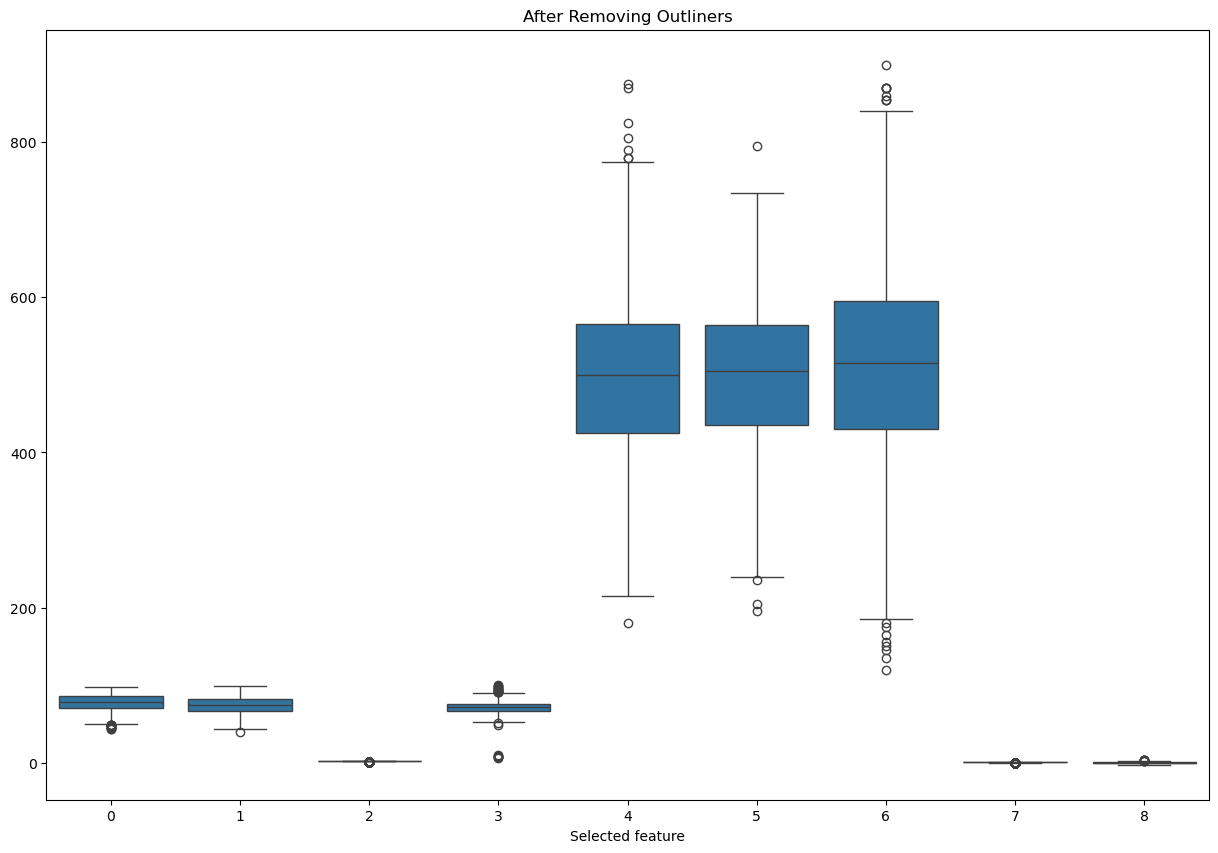

In [95]:
plt.figure(figsize=(15,10))
sns.boxplot(data=new_X).set(xticklabels=list(range(10)), xlabel="Selected feature", title="After Removing Outliners")
plt.show()

## Mô hình hóa các đặc trưng được chọn và so sánh 


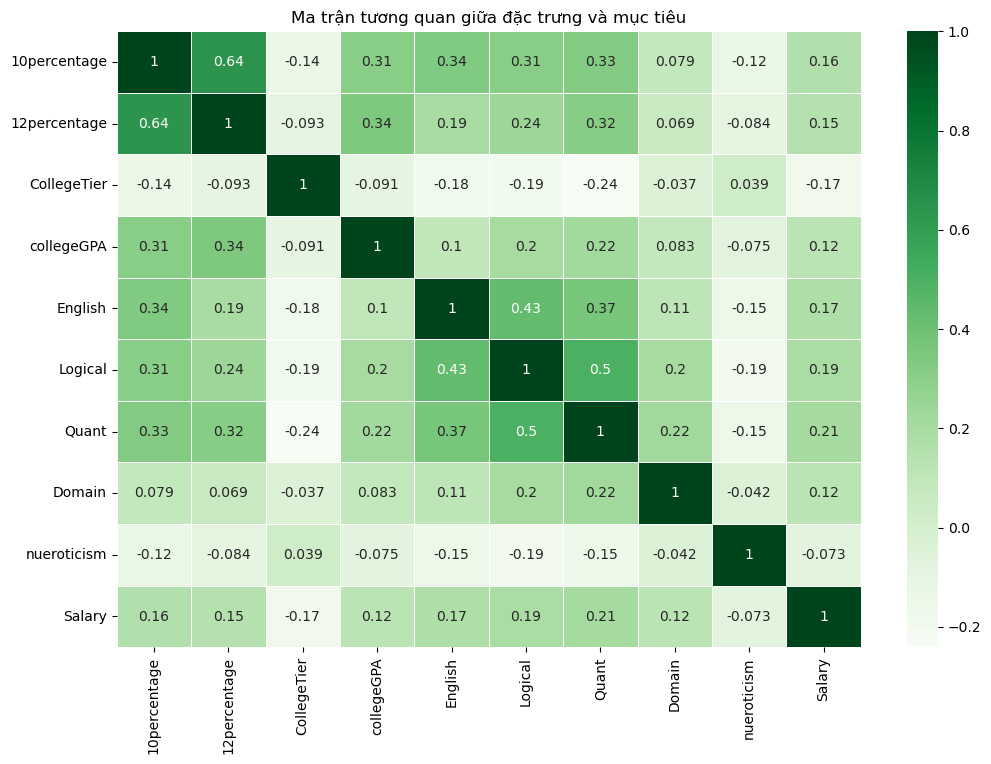

In [96]:
# Tính ma trận tương quan giữa các đặc trưng
combined_data = pd.concat([new_X, y_train], axis=1)
# Tính ma trận tương quan
correlation_matrix = combined_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="Greens", linewidths=.5)
plt.title("Ma trận tương quan giữa đặc trưng và mục tiêu")
plt.show()

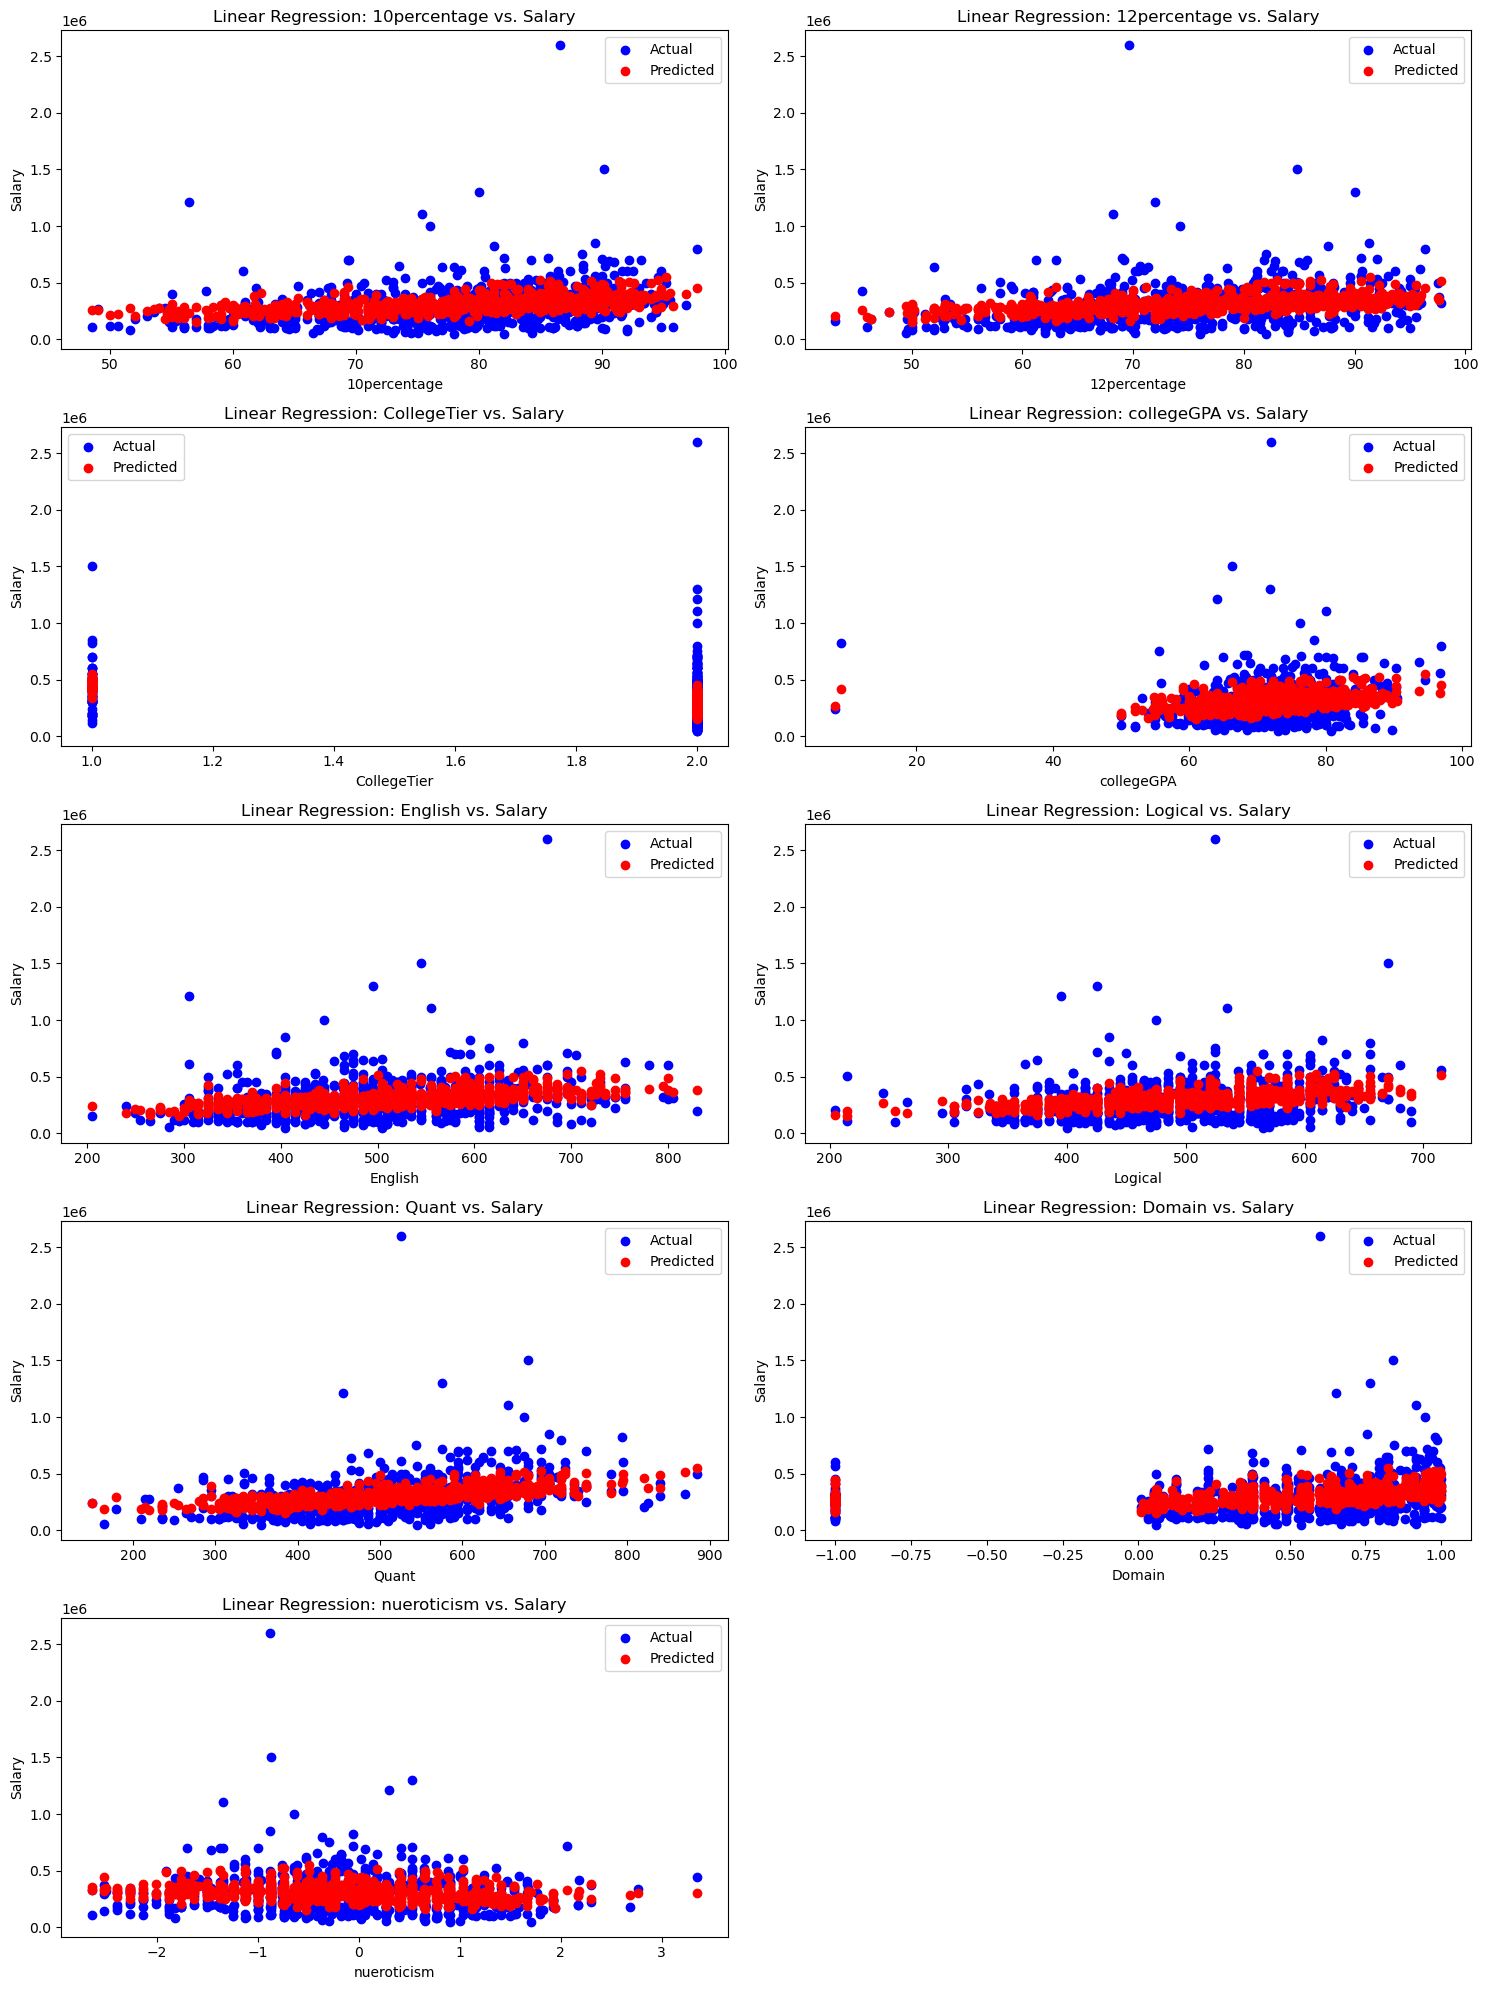

In [97]:
# Các đặc trưng đã chọn
selected_features = ['10percentage', '12percentage', 'CollegeTier', 'collegeGPA', 'English', 'Logical', 'Quant', 'Domain', 'nueroticism']

# Tạo và huấn luyện mô hình hồi quy tuyến tính
model = LinearRegression()
model.fit(new_X, y_train)

# Vẽ biểu đồ hồi quy tuyến tính cho từng đặc trưng
num_features = len(selected_features)
num_rows = (num_features - 1) // 2 + 1
num_cols = 2

plt.figure(figsize=(15, 20))

for i, feature in enumerate(selected_features):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(X_test[feature], y_test, color='blue', label='Actual')
    plt.scatter(X_test[feature], model.predict(X_test[selected_features]), color='red', label='Predicted')
    plt.xlabel(feature)
    plt.ylabel('Salary')
    plt.title('Linear Regression: {} vs. Salary'.format(feature))
    plt.legend()

plt.tight_layout()
plt.show()

## Chọn model

In [98]:
selected_features = ['10percentage','12percentage','CollegeTier','collegeGPA','English',	'Logical',	'Quant',	'Domain',	'nueroticism']
X_train_1d = X_train[selected_features].copy()
X_test_1d = X_test[selected_features].copy()
y_train_1d = y_train.copy()
#Model 1 -> Using all feature after selected

X_train_1d['Quant_squared'] = np.square(X_train_1d['Quant'])
X_train_1d['Quant_squared_root'] = np.sqrt(X_train_1d['Quant'])
X_train_1d['Logical_squared_root'] = np.sqrt(X_train_1d['Logical'])
X_train_1d['English_squared_root'] = np.sqrt(X_train_1d['English'])
X_train_1d['collegeGPA_squared_root'] = np.sqrt(X_train_1d['collegeGPA'])
X_train_1d['CollegeTier_squared_root'] = np.sqrt(X_train_1d['CollegeTier'])

X_test_1d['Quant_squared'] = np.square(X_test_1d['Quant'])
X_test_1d['Quant_squared_root'] = np.sqrt(X_test_1d['Quant'])
X_test_1d['Logical_squared_root'] = np.sqrt(X_test_1d['Logical'])
X_test_1d['English_squared_root'] = np.sqrt(X_test_1d['English'])
X_test_1d['collegeGPA_squared_root'] = np.sqrt(X_test_1d['collegeGPA'])
X_test_1d['CollegeTier_squared_root'] = np.sqrt(X_test_1d['CollegeTier'])

X_train_1d['TotalScore_squared_root'] = np.sqrt(X_train_1d['English']) + np.sqrt(X_train_1d['Logical']) + np.sqrt(X_train_1d['Quant'])
X_train_1d['TotalGPA_squared_root'] = np.sqrt(X_train_1d['10percentage']) + np.sqrt(X_train_1d['12percentage']) 
X_train_1d['College_squared_root'] = np.sqrt(X_train_1d['CollegeTier']) + np.sqrt(X_train_1d['collegeGPA']) 

X_test_1d['TotalScore_squared_root'] = np.sqrt(X_test_1d['English']) + np.sqrt(X_test_1d['Logical']) + np.sqrt(X_test_1d['Quant'])
X_test_1d['TotalGPA_squared_root'] = np.sqrt(X_test_1d['10percentage']) + np.sqrt(X_test_1d['12percentage']) 
X_test_1d['College_squared_root'] = np.sqrt(X_test_1d['CollegeTier']) + np.sqrt(X_test_1d['collegeGPA']) 

X_train_1d['10percentage_squared_root'] = np.sqrt(X_train_1d['10percentage'])
X_train_1d['12percentage_squared_root'] = np.sqrt(X_train_1d['12percentage'])
X_train_1d['12percentage_squared_root'] = np.sqrt(X_train_1d['12percentage'])


X_test_1d['10percentage_squared_root'] = np.sqrt(X_test_1d['10percentage'])
X_test_1d['12percentage_squared_root'] = np.sqrt(X_test_1d['12percentage'])
X_test_1d['12percentage_squared_root'] = np.sqrt(X_test_1d['12percentage'])


models = [
    #Model 1: Dùng tất cả các đặc trưng chọn được
    ['10percentage','12percentage','CollegeTier','collegeGPA','English',	'Logical',	'Quant',	'Domain',	'nueroticism'], #Model 1: Use all
    ['10percentage','12percentage','CollegeTier','collegeGPA','English', 'Logical',	'Quant_squared',	'Domain',	'nueroticism'],  # Model 2: Square one best value 
    ['10percentage','12percentage','CollegeTier','collegeGPA','English', 'Logical',	'Quant_squared_root',	'Domain',	'nueroticism'],  # Model 3: Square root one best value 
    ['10percentage','12percentage','CollegeTier','collegeGPA','English', 'Logical_squared_root',	'Quant_squared_root',	'Domain',	'nueroticism'],  # Model 4: Square root two best values
    ['10percentage_squared_root','12percentage_squared_root','CollegeTier_squared_root','collegeGPA_squared_root','English_squared_root', 'Logical_squared_root',	'Quant_squared_root',	'Domain',	'nueroticism'],  # Model 5 : quare root seven best values
    ['10percentage','12percentage','CollegeTier','collegeGPA','TotalScore_squared_root',	'Domain',	'nueroticism'],  # Model 6: Combine three sqrt values of Score
    ['TotalGPA_squared_root','CollegeTier','collegeGPA','TotalScore_squared_root',	'Domain',	'nueroticism'],  # Model 7: Combine two sqrt best values of GPA
    ['TotalGPA_squared_root','College_squared_root','TotalScore_squared_root',	'Domain',	'nueroticism'],  # Model 8: Combine College

   
 

]
X_test_1d

,10percentage,12percentage,CollegeTier,collegeGPA,English,Logical,Quant,Domain,nueroticism,Quant_squared,Quant_squared_root,Logical_squared_root,English_squared_root,collegeGPA_squared_root,CollegeTier_squared_root,TotalScore_squared_root,TotalGPA_squared_root,College_squared_root,10percentage_squared_root,12percentage_squared_root
0,61.63,53.17,2,60.00,485,415,215,0.450877,-0.7603,46225,14.662878,20.371549,22.022716,7.745967,1.414214,57.057143,15.142254,9.160180,7.850478,7.291776
1,72.40,73.40,2,68.25,485,625,655,0.819417,0.5323,429025,25.592968,25.000000,22.022716,8.261356,1.414214,72.615683,17.076199,9.675569,8.508819,8.567380
2,79.00,83.40,2,73.30,425,515,595,0.600057,0.4442,354025,24.392622,22.693611,20.615528,8.561542,1.414214,67.701761,18.020554,9.975755,8.888194,9.132360
3,73.00,69.00,2,65.50,465,480,415,0.622643,0.6530,172225,20.371549,21.908902,21.563859,8.093207,1.414214,63.844310,16.850628,9.507421,8.544004,8.306624
4,92.00,72.00,2,66.00,500,440,500,0.819417,0.9066,250000,22.360680,20.976177,22.360680,8.124038,1.414214,65.697537,18.076944,9.538252,9.591663,8.485281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,78.00,72.00,2,73.40,490,470,500,0.053160,-1.5021,250000,22.360680,21.679483,22.135944,8.567380,1.414214,66.176107,17.317042,9.981594,8.831761,8.485281
746,88.53,83.88,2,77.10,595,585,565,0.960603,0.0623,319225,23.769729,24.186773,24.392622,8.780661,1.414214,72.349124,18.567641,10.194874,9.409038,9.158603
747,87.00,71.00,2,68.00,510,495,345,0.842248,-1.3753,119025,18.574176,22.248595,22.583180,8.246211,1.414214,63.405951,17.753529,9.660425,9.327379,8.426150
748,66.80,56.00,2,52.00,465,435,555,0.793581,-1.1128,308025,23.558438,20.856654,21.563859,7.211103,1.414214,65.978950,15.656441,8.625316,8.173127,7.483315


## Thử nghiệm, so sánh các mô hình

In [99]:
# Phần code cho yêu cầu 1d

best_model = None
best_mae = float('inf')
results = []
list_mae_1d = []
# Loop through each model
for model_features in models:
    X = X_train_1d[model_features].copy()
    y = y_train.copy()
    model = LinearRegression()
    # Perform k-fold Cross Validation (k=5)
    mae_scores = -cross_val_score(model, X,  y, cv=5, scoring='neg_mean_absolute_error')
    # Calculate average MAE
    avg_mae = mae_scores.mean()
    # Update best model if necessary
    if avg_mae < best_mae:
        best_mae = avg_mae
        best_model = model_features
    # Store the results
    results.append((model_features, avg_mae))
print('The best model is:', best_model)
prediction = pd.DataFrame(results, columns=['Feature', 'MAE'])
prediction
# Print the results
# print("Results from k-fold Cross Validation:")
# for idx, (model_features, avg_mae) in enumerate(results, start=1):
#      print(f"{idx}. Model using: {', '.join(model_features)}: {avg_mae:.3f}")
# print("\nBest Model:", best_model)
# Tìm ra mô hình tốt nhất (tự thiết kế bởi sinh viên)
# In ra các kết quả cross-validation như yêu cầu

The best model is: ['TotalGPA_squared_root', 'CollegeTier', 'collegeGPA', 'TotalScore_squared_root', 'Domain', 'nueroticism']


,Feature,MAE
0,"[10percentage, 12percentage, CollegeTier, coll...",113953.896595
1,"[10percentage, 12percentage, CollegeTier, coll...",114102.328928
2,"[10percentage, 12percentage, CollegeTier, coll...",113925.041917
3,"[10percentage, 12percentage, CollegeTier, coll...",113901.646293
4,"[10percentage_squared_root, 12percentage_squar...",114012.032299
5,"[10percentage, 12percentage, CollegeTier, coll...",113802.466420
6,"[TotalGPA_squared_root, CollegeTier, collegeGP...",113789.924647
7,"[TotalGPA_squared_root, College_squared_root, ...",113912.215636


In [100]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
X_train_clone_1d = X_train_1d[best_model].copy()
y_train_clone_1d = y_train_1d
model_1d = LinearRegression()
model_1d.fit(X_train_clone_1d, y_train_clone_1d)


LinearRegression()

In [101]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
X_test_clone_1d = X_test_1d[best_model].copy()
y_test_clone_1d = y_test.copy()
y_hat_1d = model_1d.predict(X_test_clone_1d)
print('MAE:', mean_absolute_error(y_test_clone_1d, y_hat_1d))

MAE: 104639.67979672305


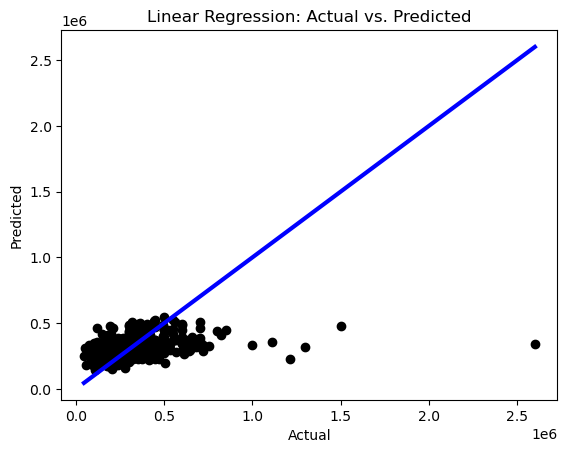

In [102]:
# Scatter plot of actual vs. predicted
plt.scatter(y_test_clone_1d, y_hat_1d, color="black")
plt.plot([y_test_clone_1d.min(), y_test_clone_1d.max()], [y_test_clone_1d.min(), y_test_clone_1d.max()], color='blue', linewidth=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Actual vs. Predicted')
plt.show()

In [103]:
print("Công thức mô hình hồi quy: ")
result = f"{model_1d.intercept_:.3f}"  # w0 (intercept)
for i, coef in enumerate(model_1d.coef_):
    result += f" + {coef:.3f} * {best_model[i]}"
print("Salary =", result)

Công thức mô hình hồi quy: 
Salary = -222966.241 + 13260.499 * TotalGPA_squared_root + -101433.935 * CollegeTier + 1284.218 * collegeGPA + 5741.998 * TotalScore_squared_root + 34875.747 * Domain + -5391.522 * nueroticism


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = -222966.241 + 13260.499 * TotalGPA_squared_root + -101433.935 * CollegeTier + 1284.218 * collegeGPA + 5741.998 * TotalScore_squared_root + 34875.747 * Domain + -5391.522 * nueroticism$$